In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

# Preamble (tools)
import numpy as np
import collections
import contextlib
import functools
import itertools
import more_itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Preamble (ML)
np.random.seed(2027)  # set random seed

#import tensorflow as tf
#tf.random.set_seed(2027)  # set random seed

#import dask
#import dask.array as da

In [2]:
# Preamble (EMTF)
from emtf_nbtools import (get_logger, get_colormap, hist2d_on_binned_data,
                          hist_on_binned_data, emtf_nbtools)

from emtf_algos import *

try:
  import emtf_nnet
except ImportError:
  raise ImportError('Could not import emtf_nnet. It can be found at '
                    'https://github.com/jiafulow/emtf-nnet')

# Get plot style and color map
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

# Get logger
logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'N/A')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
#logger.info('Using tensorflow : {}'.format(tf.__version__))
#logger.info('Using keras      : {}'.format(tf.keras.__version__))
#logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
#logger.info('Using dask       : {}'.format(dask.__version__))
logger.info('Using emtf-nnet  : {}'.format(emtf_nnet.__version__))

[INFO    ] Using cmssw      : CMSSW_11_1_7
[INFO    ] Using python     : 3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]
[INFO    ] Using numpy      : 1.20.3
[INFO    ] Using matplotlib : 3.4.2
[INFO    ] Using emtf-nnet  : 0.0.2-dev


In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
#zone = 0
zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

maxevents = 200_000
#maxevents = -1

# Input files
signal_fname = 'signal.210922.npz'
signal_dxy_fname = 'signal_dxy.210922.npz'
bkgnd_fname = 'bkgnd.210922.npz'

logger.info('Using settings   : |')
logger.info('.. zone          : {}'.format(zone))
logger.info('.. timezone      : {}'.format(timezone))
logger.info('.. maxevents     : {}'.format(maxevents))

[INFO    ] Using settings   : |
[INFO    ] .. zone          : 1
[INFO    ] .. timezone      : 0
[INFO    ] .. maxevents     : 200000


### Load data

In [4]:
def load_signal(fname):
  logger.info('Loading from {}'.format(fname))
  with np.load(fname) as loaded:
    out_part = loaded['out_part']
    out_hits_values = loaded['out_hits_values']
    out_hits_row_splits = loaded['out_hits_row_splits']
    out_hits_shape = (out_hits_row_splits.shape[0] - 1,) + (None,) + out_hits_values.shape[1:]
    out_simhits_values = loaded['out_simhits_values']
    out_simhits_row_splits = loaded['out_simhits_row_splits']
    out_simhits_shape = (out_simhits_row_splits.shape[0] - 1,) + (None,) + out_simhits_values.shape[1:]
  logger.info('out_part: {}, out_hits: {}, out_simhits: {}'.format(
      (out_part.shape, out_part.dtype.name),
      (out_hits_shape, out_hits_values.dtype.name),
      (out_simhits_shape, out_simhits_values.dtype.name)))
  return (out_part, (out_hits_values, out_hits_row_splits), (out_simhits_values, out_simhits_row_splits))


def load_bkgnd(fname):
  logger.info('Loading from {}'.format(fname))
  with np.load(fname) as loaded:
    bkg_aux = loaded['out_aux']
    bkg_hits_values = loaded['out_hits_values']
    bkg_hits_row_splits = loaded['out_hits_row_splits']
    bkg_hits_shape = (bkg_hits_row_splits.shape[0] - 1,) + (None,) + bkg_hits_values.shape[1:]
  logger.info('bkg_aux: {} bkg_hits: {}'.format(
      (bkg_aux.shape, bkg_aux.dtype.name),
      (bkg_hits_shape, bkg_hits_values.dtype.name)))
  return (bkg_aux, (bkg_hits_values, bkg_hits_row_splits))

In [5]:
# Load data
out_part, out_hits, out_simhits = load_signal(signal_fname)

bkg_aux, bkg_hits = load_bkgnd(bkgnd_fname)

out_hits = emtf_nnet.ragged.RaggedTensorValue(out_hits[0], out_hits[1])
out_simhits = emtf_nnet.ragged.RaggedTensorValue(out_simhits[0], out_simhits[1])
bkg_hits = emtf_nnet.ragged.RaggedTensorValue(bkg_hits[0], bkg_hits[1])

[INFO    ] Loading from signal.210922.npz
[INFO    ] out_part: ((2000000, 10), 'float32'), out_hits: ((2000000, None, 17), 'int32'), out_simhits: ((2000000, None, 17), 'int32')
[INFO    ] Loading from bkgnd.210922.npz
[INFO    ] bkg_aux: ((12592764, 2), 'int32') bkg_hits: ((12592764, None, 17), 'int32')


### More settings

In [6]:
# particle info
_part_fields = [
  'part_invpt',
  'part_eta',
  'part_phi',
  'part_vx',
  'part_vy',
  'part_vz',
  'part_d0',
  'part_bx',
  'part_sector',
  'part_zone',
]
PartFields = collections.namedtuple('PartFields', _part_fields)
part_fields = PartFields(*range(len(_part_fields)))

# sector_hits info
_sector_hits_fields = [
  'emtf_chamber',
  'emtf_segment',
  'emtf_phi',
  'emtf_bend',
  'emtf_theta1',
  'emtf_theta2',
  'emtf_qual1',
  'emtf_qual2',
  'emtf_time',
  'zones',
  'timezones',
  'cscfr',
  'gemdl',
  'bx',
  'emtf_site',
  'emtf_host',
  'valid',
]
SectorHitsFields = collections.namedtuple('SectorHitsFields', _sector_hits_fields)
sector_hits_fields = SectorHitsFields(*range(len(_sector_hits_fields)))

In [7]:
# Info regarding phi unit
# 80 deg is converted to (80.*60)/16 = 300 units.
# 30 deg is converted to (30.*60)/16 = 112.5 units.
# 300 units aligned to 16-bit is np.floor(300./16)*16 = 288 units.
# 112.5 units aligned to 16-bit is np.floor(112.5/16) * 16 = 112 units,
# 112 is then lowered to the closest odd number 111.

# Image format
num_channels = 1
num_cols = 288  # 80 degrees
num_rows = 8
image_format = (num_rows, num_cols, num_channels)
image_stride = (min_emtf_strip, max_emtf_strip, coarse_emtf_strip)
assert ((max_emtf_strip - min_emtf_strip) // coarse_emtf_strip) == num_cols

# Box image format
num_box_rows = num_rows
num_box_cols = 111  # 30 degrees
num_box_channels = num_channels
box_image_format = (num_box_rows, num_box_cols, num_box_channels)
box_col_offset = (num_box_cols - 1) // 2  # (111-1)/2 = 55
box_col_padding = 36  # ad-hoc, reduces pattern winsz to ~20 deg
assert (num_box_cols % 2) == 1

# Zone-dependent settings
if zone == 0:
  invpt_bins = np.array([-0.49486, -0.30914, -0.18457, -0.06144, 0.06144, 0.18457, 0.30914, 0.49486])
  dzero_bins = np.array([-149.05426, -81.99509, -27.70436, -3.31677, 3.31677, 27.70436, 81.99509, 149.05426])
  invpt_thres = 0.5
  eta_thres = 2.45
  anchor_row = 4  # ME2/1
  activation = 0.06
elif zone == 1:
  invpt_bins = np.array([-0.49430, -0.32499, -0.20098, -0.06069, 0.06069, 0.20098, 0.32499, 0.49430])
  dzero_bins = np.array([-148.39244, -75.48091, -24.77920, -2.74001, 2.74001, 24.77920, 75.48091, 148.39244])
  invpt_thres = 0.45
  eta_thres = 2.05
  anchor_row = 4  # ME2/1
  activation = 0.06
elif zone == 2:
  invpt_bins = np.array([-0.46452, -0.25713, -0.15333, -0.06148, 0.06148, 0.15333, 0.25713, 0.46452])
  dzero_bins = np.array([-148.38953, -73.95163, -24.58335, -3.20768, 3.20768, 24.58335, 73.95163, 148.38953])
  invpt_thres = 0.45
  eta_thres = 1.65
  anchor_row = 3  # ME2/2
  activation = 0.05
else:
  raise RuntimeError('Could not recognize zone: {}'.format(zone))

num_invpt_bins = len(invpt_bins) - 1
num_dzero_bins = len(dzero_bins) - 1


def digitize_d0_and_invpt(d0, invpt):
  # returns (dzero_bin, invpt_bin)
  idx0 = emtf_nbtools.hist_digitize_inclusive(d0, dzero_bins)
  idx1 = emtf_nbtools.hist_digitize_inclusive(invpt, invpt_bins)
  return (idx0, idx1)

### Zone selection

In [8]:
# Make and apply zone_mask

part_zone = out_part[:, part_fields.part_zone].astype(np.int32)
zone_mask = (part_zone == zone)


pt_and_eta_mask = ((np.abs(out_part[:, part_fields.part_invpt]) <= invpt_thres) &
                   (np.abs(out_part[:, part_fields.part_eta]) <= eta_thres))
zone_mask &= pt_and_eta_mask

atleast_1hit_mask = (out_simhits.row_lengths != 0)
zone_mask &= atleast_1hit_mask

zone_part = out_part[zone_mask]
zone_hits = emtf_nnet.ragged.ragged_row_boolean_mask(out_hits, zone_mask)
zone_simhits = emtf_nnet.ragged.ragged_row_boolean_mask(out_simhits, zone_mask)

logger.info('zone_part: {} zone_hits: {} zone_simhits: {}'.format(
    zone_part.shape, zone_hits.shape, zone_simhits.shape))

[INFO    ] zone_part: (636234, 10) zone_hits: (636234, None, 17) zone_simhits: (636234, None, 17)


In [9]:
# Debug
with np.printoptions(linewidth=100, threshold=1000):
  for ievt in range(5):
    print('Event {}'.format(ievt))
    print(zone_part[ievt])
    print(zone_hits[ievt])
    print(zone_simhits[ievt])

Event 0
[-1.1481526e-01 -1.8236134e+00 -3.1007726e+00 -3.1513703e-04 -5.3637777e-05 -4.3685612e-01
 -4.0732793e-05  0.0000000e+00  8.0000000e+00  1.0000000e+00]
[[  11    0 4582    4   33    0    6    8    0    2    4    1    0    0    0    0    1]
 [  20    0 4688    0   34    0    6   10    0    2    4    1    0    0    2    3    1]
 [  29    0 4704    0   34    0    6   10    0    2    4    0    0    0    3    5    1]
 [  65    0 4568    0   35    0    0    0    0    2    4    1    1    0    9    9    1]
 [  74    0 4685    0   35    0    0    0    0    2    4    1    1    0   10   12    1]
 [  83    0 4709    0   34    0    0    0    0    2    4    0    1    0    7   14    1]
 [  98    0 4705    0   35    0    0    0   -1    2    4    0    1    0    8   17    1]]
[[  11    0 4580    0   34    0    0    0    0    2    4    0    0    0    0    0    1]
 [  20    0 4691    0   34    0    0    0    0    2    4    0    0    0    2    3    1]
 [  29    0 4705    0   34    0    0    0    0

### Build images

In [10]:
# Build images

def build_zone_images():
  # zone_images_gt are made from sim hits, while zone_images are made from trigger primitives.
  # 'gt' stands for ground truth.
  zone_images_gt = np.zeros((zone_part.shape[0],) + image_format, dtype=bool)
  zone_images = np.zeros((zone_part.shape[0],) + image_format, dtype=bool)

  # Get hit variables
  zone_simhits_row_splits = zone_simhits.row_splits
  zone_simhits_emtf_phi = zone_simhits.values[:, sector_hits_fields.emtf_phi]
  zone_simhits_emtf_host = zone_simhits.values[:, sector_hits_fields.emtf_host]
  zone_simhits_zones = zone_simhits.values[:, sector_hits_fields.zones]
  zone_simhits_timezones = zone_simhits.values[:, sector_hits_fields.timezones]
  zone_simhits_valid = zone_simhits.values[:, sector_hits_fields.valid].astype(bool)

  zone_hits_row_splits = zone_hits.row_splits
  zone_hits_emtf_phi = zone_hits.values[:, sector_hits_fields.emtf_phi]
  zone_hits_emtf_host = zone_hits.values[:, sector_hits_fields.emtf_host]
  zone_hits_zones = zone_hits.values[:, sector_hits_fields.zones]
  zone_hits_timezones = zone_hits.values[:, sector_hits_fields.timezones]
  zone_hits_valid = zone_hits.values[:, sector_hits_fields.valid].astype(bool)

  # Perform (vectorized) calculations
  zone_simhits_valid = ((zone_simhits_zones & (1 << ((num_emtf_zones - 1) - zone))).astype(bool) &
                        (zone_simhits_timezones & (1 << ((num_emtf_timezones - 1) - timezone))).astype(bool) &
                        zone_simhits_valid)
  zone_simhits_img_row = find_emtf_img_row(zone_simhits_emtf_host, zone=zone)
  zone_simhits_img_col = find_emtf_img_col(zone_simhits_emtf_phi)

  zone_hits_valid = ((zone_hits_zones & (1 << ((num_emtf_zones - 1) - zone))).astype(bool) &
                     (zone_hits_timezones & (1 << ((num_emtf_timezones - 1) - timezone))).astype(bool) &
                     zone_hits_valid)
  zone_hits_img_row = find_emtf_img_row(zone_hits_emtf_host, zone=zone)
  zone_hits_img_col = find_emtf_img_col(zone_hits_emtf_phi)

  # Build zone_images_gt
  _build_zone_images(zone_simhits_row_splits,
                     zone_simhits_valid,
                     zone_simhits_img_row,
                     zone_simhits_img_col,
                     zone_images_gt)
  # Build zone_images
  _build_zone_images(zone_hits_row_splits,
                     zone_hits_valid,
                     zone_hits_img_row,
                     zone_hits_img_col,
                     zone_images)
  return (zone_images_gt, zone_images)


def _build_zone_images(zone_simhits_row_splits,
                       zone_simhits_valid,
                       zone_simhits_img_row,
                       zone_simhits_img_col,
                       zone_images_gt):
  # If valid, set bit at (row, col, channel) to 1
  def func(ievt, valid, row, col):
    if valid and (row >= 0) and (col >= 0):
      zone_images_gt[ievt, row, col, 0] = 1

  zone_simhits_row_indices = emtf_nnet.ragged.ragged_row_splits_to_segment_ids(zone_simhits_row_splits)
  iterables = zip(zone_simhits_row_indices, zone_simhits_valid, zone_simhits_img_row, zone_simhits_img_col)
  more_itertools.consume(itertools.starmap(func, iterables))

In [11]:
# Display images

def display_zone_image(img, cmap=cm.blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(figsize=figsize)
  ax.imshow(img[..., 0], origin='lower', interpolation='none', aspect='auto', cmap=cmap,
            vmin=0, vmax=1.6)
  ax.set_yticks(range(len(img_row_labels[zone])))
  ax.set_yticklabels(img_row_labels[zone], fontsize=7)
  ax.grid(False)
  plt.show()

In [12]:
%%time

zone_images_gt, zone_images = build_zone_images()

logger.info('zone_images_gt: {} zone_images: {}'.format(zone_images_gt.shape, zone_images.shape))

[INFO    ] zone_images_gt: (636234, 8, 288, 1) zone_images: (636234, 8, 288, 1)


CPU times: user 29.3 s, sys: 1.14 s, total: 30.4 s
Wall time: 30.4 s


In [13]:
# Remake zone_mask

# Reduce on axis=(-2,-1), then count num of stations on axis=-3 (row)
#atleast_2stns_mask = (zone_images_gt.any(axis=-1).any(axis=-1).sum(axis=-1) >= 2)
atleast_2stns_mask = zone_images_gt.any(axis=-1).any(axis=-1)
if zone == 0:
  atleast_2stns_mask = np.stack([
      atleast_2stns_mask[..., [0,]].any(axis=-1),
      atleast_2stns_mask[..., [1,2,]].any(axis=-1),
      atleast_2stns_mask[..., [3,4,]].any(axis=-1),
      atleast_2stns_mask[..., [5,6,]].any(axis=-1),
      atleast_2stns_mask[..., [7,]].any(axis=-1),
  ], axis=-1).sum(axis=-1) >= 2
elif zone == 1:
  atleast_2stns_mask = np.stack([
      atleast_2stns_mask[..., [0,1,]].any(axis=-1),
      atleast_2stns_mask[..., [2,]].any(axis=-1),
      atleast_2stns_mask[..., [3,4,]].any(axis=-1),
      atleast_2stns_mask[..., [5,6,]].any(axis=-1),
      atleast_2stns_mask[..., [7,]].any(axis=-1),
  ], axis=-1).sum(axis=-1) >= 2
elif zone == 2:
  atleast_2stns_mask = np.stack([
      atleast_2stns_mask[..., [0,1,]].any(axis=-1),
      atleast_2stns_mask[..., [2,3,]].any(axis=-1),
      atleast_2stns_mask[..., [4,5,]].any(axis=-1),
      atleast_2stns_mask[..., [6,7,]].any(axis=-1),
  ], axis=-1).sum(axis=-1) >= 2

zone_mask = atleast_2stns_mask

zone_part = zone_part[zone_mask]
zone_hits = emtf_nnet.ragged.ragged_row_boolean_mask(zone_hits, zone_mask)
zone_simhits = emtf_nnet.ragged.ragged_row_boolean_mask(zone_simhits, zone_mask)

zone_images_gt = zone_images_gt[zone_mask]
zone_images = zone_images[zone_mask]

zone_part_pt_values = np.reciprocal(np.abs(zone_part[:, part_fields.part_invpt]))
zone_part_eta_values = zone_part[:, part_fields.part_eta]

logger.info('zone_images_gt: {} zone_images: {}'.format(zone_images_gt.shape, zone_images.shape))

[INFO    ] zone_images_gt: (634748, 8, 288, 1) zone_images: (634748, 8, 288, 1)


Event 0
pt: 8.710 eta: -1.824


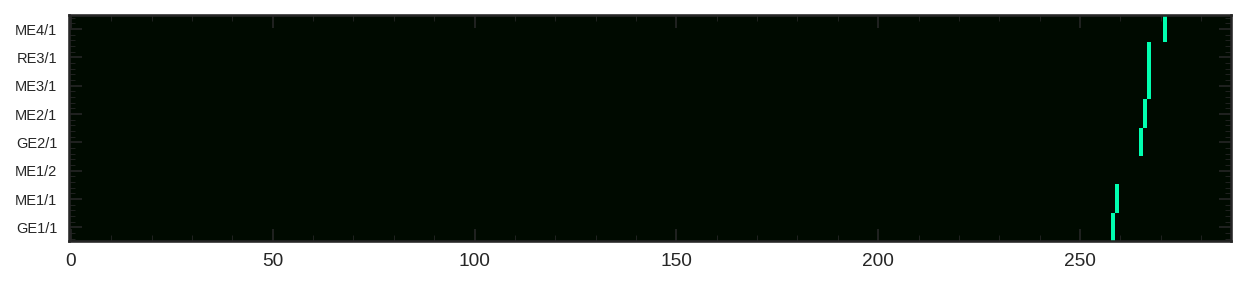

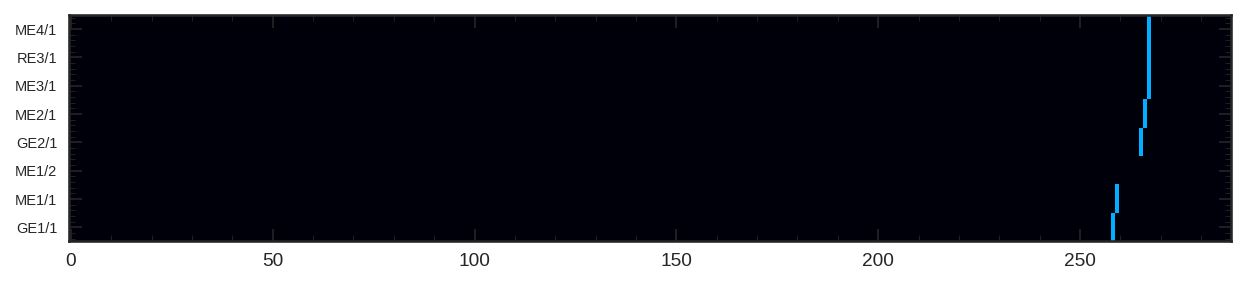

Event 1
pt: 2.788 eta: -1.671


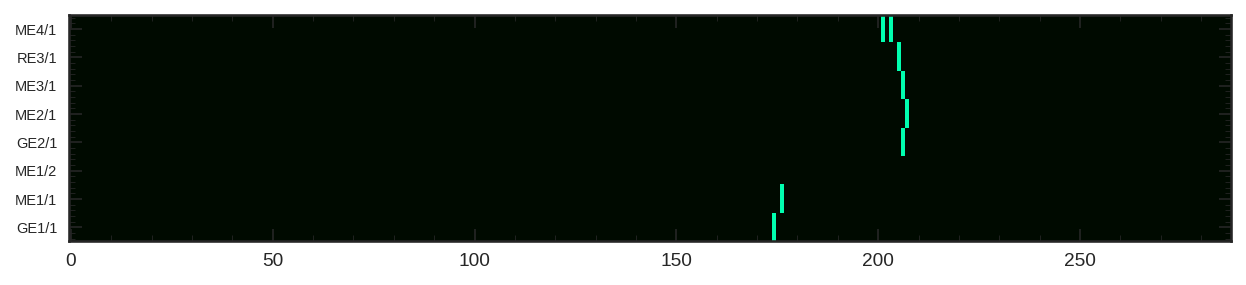

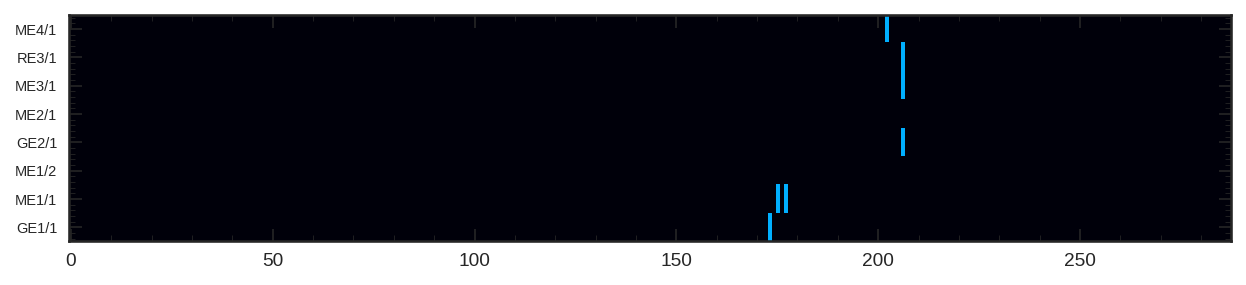

Event 2
pt: 15.031 eta: -1.654


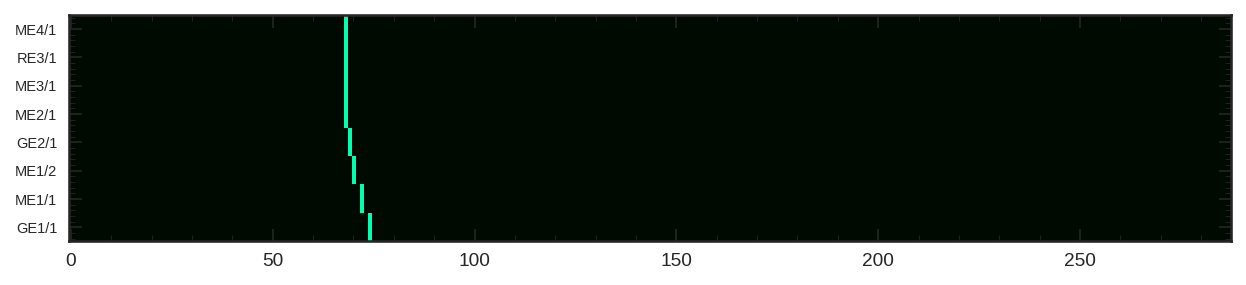

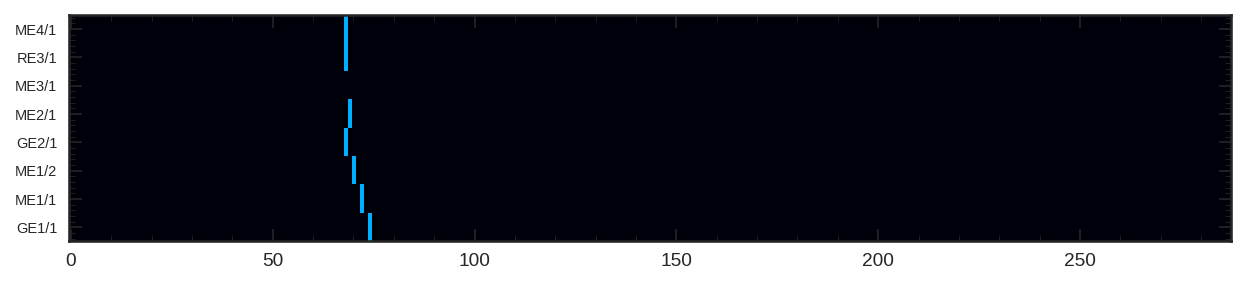

Event 3
pt: 9.663 eta: -1.643


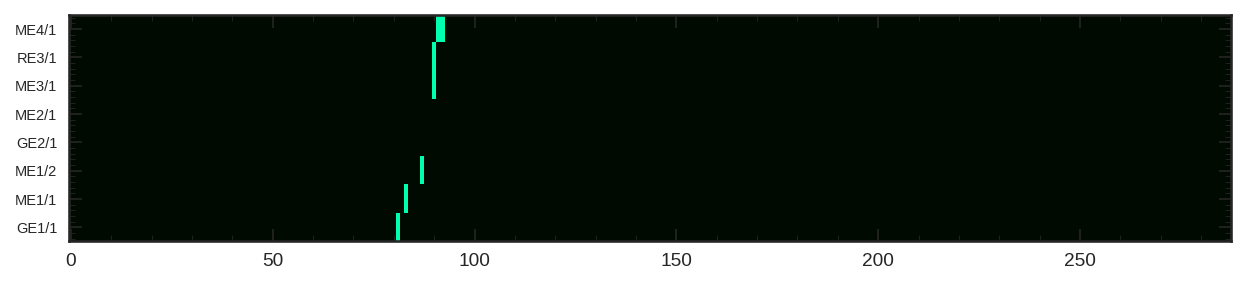

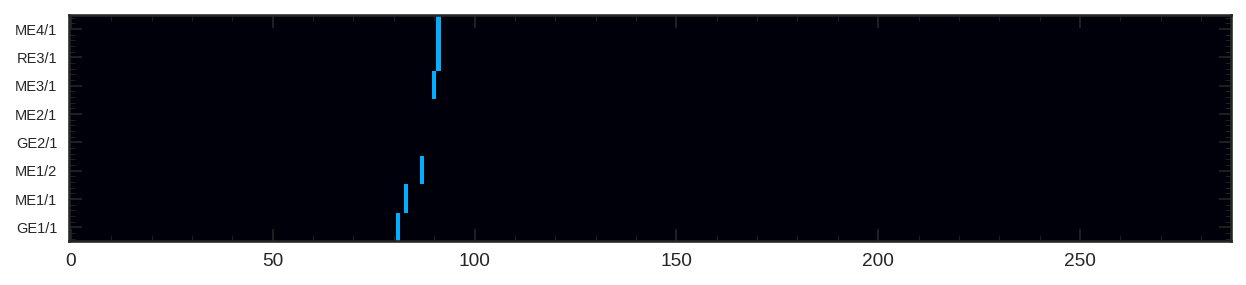

Event 4
pt: 30.876 eta: -1.736


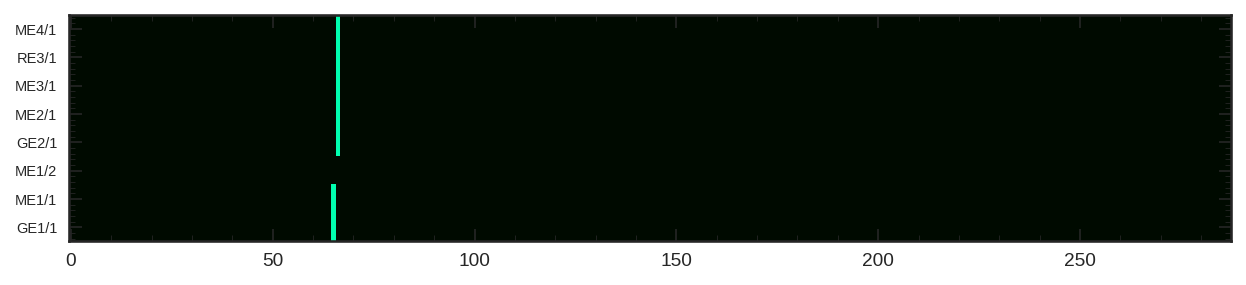

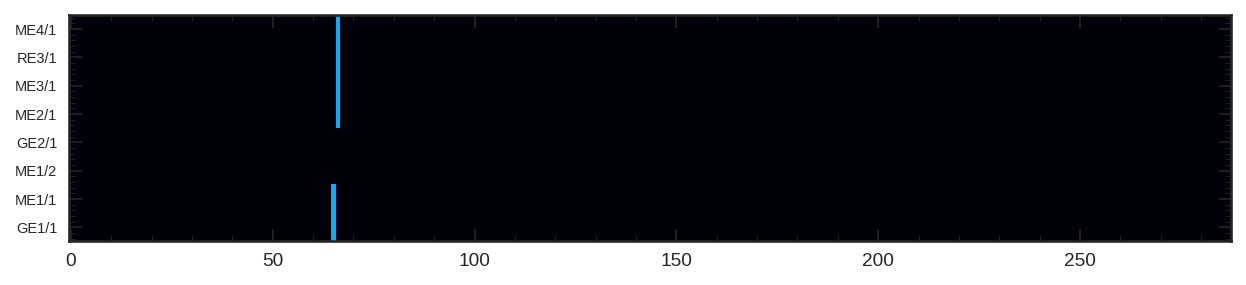

In [14]:
# Debug
for ievt in range(5):
  print('Event {}'.format(ievt))
  print('pt: {:.3f} eta: {:.3f}'.format(zone_part_pt_values[ievt], zone_part_eta_values[ievt]))
  display_zone_image(zone_images_gt[ievt], cmap=cm.green_hot)
  display_zone_image(zone_images[ievt])

In [15]:
# Build boxes

def get_box_ranges(anchors):
  start = np.maximum(0, anchors - box_col_offset)
  stop = np.minimum(num_cols, anchors + box_col_offset + 1)
  b_start = np.maximum(0, num_box_cols - stop)
  b_stop = np.minimum(num_box_cols, num_cols - start)
  return (start, stop, b_start, b_stop)


def build_boxes():
  # 5 indices: (dzero_bin, invpt_bin, img_row, img_col, img_channel)
  boxes = np.zeros((num_dzero_bins, num_invpt_bins) + box_image_format, dtype=np.float32)

  box_bins = digitize_d0_and_invpt(zone_part[:, part_fields.part_d0],
                                   zone_part[:, part_fields.part_invpt])
  box_bins_mir = ((num_dzero_bins - 1) - box_bins[0],
                  (num_invpt_bins - 1) - box_bins[1])

  # Canon images
  _build_boxes(zone_images_gt,
               box_bins,
               boxes)
  # Mirror images
  _build_boxes(zone_images_gt[:, :, ::-1, :],
               box_bins_mir,
               boxes)
  return (boxes, box_bins)


def _build_boxes(zone_images_gt,
                 box_bins,
                 boxes):
  def normalize(zone_images_gt):
    norm = zone_images_gt.sum(axis=-1).sum(axis=-1)  # reduce on axis=(-2,-1)
    norm[norm == 0] = 1
    zone_images_gt = zone_images_gt.astype(np.float32) / norm[:, :, np.newaxis, np.newaxis]
    return zone_images_gt

  def func(dzero_bin, invpt_bin, img, valid, start, stop, b_start, b_stop):
    # If anchor_row is valid, accumulate 'img' sliced from 'start' to 'stop'
    # into 'box' sliced from 'b_start' to 'b_stop'
    if valid:
      box = boxes[dzero_bin, invpt_bin]
      box[:, b_start:b_stop, 0] += img[:, start:stop, 0]

  anchors_valid = np.any(zone_images_gt[:, anchor_row, :, 0], axis=-1)
  anchors = np.argmax(zone_images_gt[:, anchor_row, :, 0], axis=-1)
  box_ranges = get_box_ranges(anchors)
  zone_images_gt = normalize(zone_images_gt)

  iterables = zip(box_bins[0], box_bins[1], zone_images_gt, anchors_valid,
                  box_ranges[0], box_ranges[1], box_ranges[2], box_ranges[3])
  more_itertools.consume(itertools.starmap(func, iterables))


def postprocess_boxes(boxes, antialias=True):
  tmp_boxes = boxes.copy()
  # Apply anti-aliasing to anchor_row (ME2) and anchor_row-1 (RE2 or GE2)
  if antialias:
    kernel = np.array([1., 2., 1.], dtype=boxes.dtype)
    kernel /= kernel.sum()
    for i in range(tmp_boxes.shape[0]):
      for j in range(tmp_boxes.shape[1]):
        for k in [anchor_row, anchor_row-1]:
          for l in range(1, tmp_boxes.shape[3]-1):
            window = boxes[i, j, k, (l-1):(l+2), 0]
            tmp_boxes[i, j, k, l, 0] = (window * kernel).sum()

  # Normalization
  norm = np.sqrt(np.square(tmp_boxes).sum(axis=-1).sum(axis=-1))
  norm[norm == 0] = 1
  tmp_boxes /= norm[:, :, :, np.newaxis, np.newaxis]
  return (tmp_boxes, boxes)

In [16]:
# Display boxes

def display_boxes(boxes, cmap=None, figsize=(7.5,7.5)):
  fig, axs = plt.subplots(num_dzero_bins, num_invpt_bins, figsize=figsize, sharex=True, sharey=True,
                          gridspec_kw=dict(wspace=0.1, hspace=0.1))
  for i in range(num_dzero_bins):
    for j in range(num_invpt_bins):
      ax = axs[(num_dzero_bins-1)-i, j]  # axs[0,0] is top left
      img = boxes[i, j]
      ax.imshow(img[..., 0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.grid(False)
      for x in [-40, -20, 0, +20, +40]:  # custom grid lines
        ax.axvline(box_col_offset+x, color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

def display_box(img, cmap=None, figsize=(3,3)):
  fig, ax = plt.subplots(figsize=figsize)
  ax.imshow(img[..., 0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.grid(False)
  for x in [-40, -20, 0, +20, +40]:  # custom grid lines
    ax.axvline(box_col_offset+x, color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

In [17]:
%%time

boxes, box_bins = build_boxes()
boxes_norm, boxes = postprocess_boxes(boxes)

logger.info('boxes_norm: {} boxes: {}'.format(boxes_norm.shape, boxes.shape))

[INFO    ] boxes_norm: (7, 7, 8, 111, 1) boxes: (7, 7, 8, 111, 1)


CPU times: user 28.1 s, sys: 24.5 s, total: 52.6 s
Wall time: 52.6 s


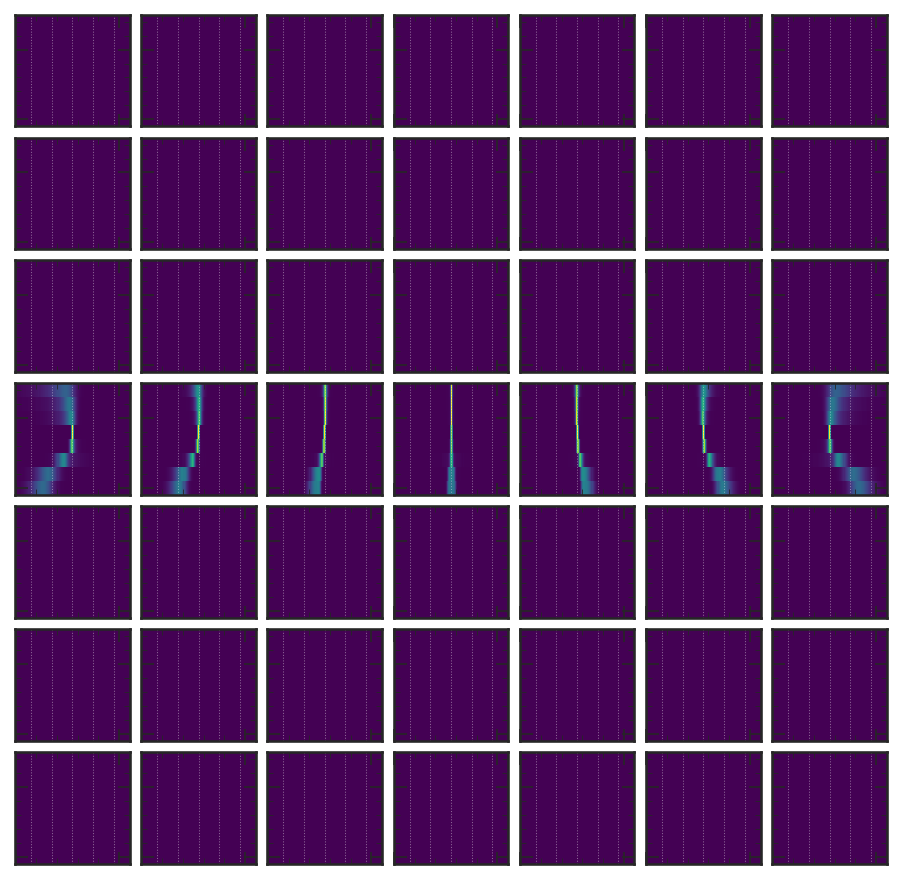

In [18]:
display_boxes(boxes_norm)

In [19]:
# Crop zone images using boxes

def build_crop_images():
  # crop_images_gt are made from sim hits, while crop_images are made from trigger primitives.
  # 'gt' stands for ground truth.
  crop_images_gt = np.zeros((zone_part.shape[0],) + box_image_format, dtype=bool)
  crop_images = np.zeros((zone_part.shape[0],) + box_image_format, dtype=bool)
  zone_images_anchors = np.zeros(zone_part.shape[0], dtype=np.int32)

  # Find zone_images_anchors
  _build_crop_images_0(zone_images_gt,
                       box_bins,
                       boxes_norm,
                       zone_images_anchors)

  # Build crop_images_gt
  _build_crop_images_1(zone_images_gt,
                       zone_images_anchors,
                       crop_images_gt)
  # Build crop_images
  _build_crop_images_1(zone_images,
                       zone_images_anchors,
                       crop_images)
  return (crop_images_gt, crop_images, zone_images_anchors)


def _build_crop_images_0(zone_images_gt,
                         box_bins,
                         boxes_norm,
                         zone_images_anchors):
  def func(ievt, dzero_bin, invpt_bin, img):
    # Pseudo 2D convolution by applying 1D convolution multiple times and summing the results
    # Note the box has to be flipped before 1D convolution
    box = boxes_norm[dzero_bin, invpt_bin]
    convolved = np.add.reduce([
        np.convolve(img[i, :, 0], box[i, ::-1, 0], mode='same')
        for i in range(img.shape[0])])
    # Get the best anchor_col
    zone_images_anchors[ievt] = np.argmax(convolved)

  iterables = zip(itertools.count(), box_bins[0], box_bins[1], zone_images_gt)
  more_itertools.consume(itertools.starmap(func, iterables))


def _build_crop_images_1(zone_images_gt,
                         zone_images_anchors,
                         crop_images_gt):
  def func(ievt, img, start, stop, b_start, b_stop):
    crop_images_gt[ievt, :, b_start:b_stop, 0] = img[:, start:stop, 0]

  box_ranges = get_box_ranges(zone_images_anchors)
  iterables = zip(itertools.count(), zone_images_gt, box_ranges[0], box_ranges[1],
                  box_ranges[2], box_ranges[3])
  more_itertools.consume(itertools.starmap(func, iterables))

In [20]:
%%time

crop_images_gt, crop_images, zone_images_anchors = build_crop_images()

logger.info('crop_images_gt: {} crop_images: {} zone_images_anchors: {}'.format(
    crop_images_gt.shape, crop_images.shape, zone_images_anchors.shape))

[INFO    ] crop_images_gt: (634748, 8, 111, 1) crop_images: (634748, 8, 111, 1) zone_images_anchors: (634748,)


CPU times: user 1min 21s, sys: 1.3 s, total: 1min 22s
Wall time: 1min 22s


Event 0
pt: 8.710 eta: -1.824


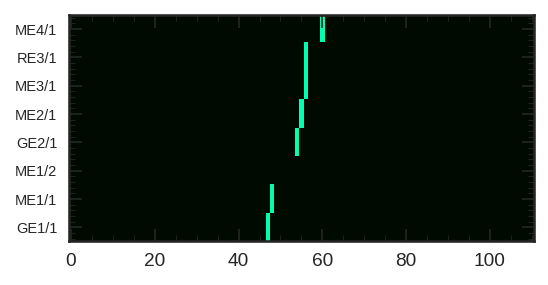

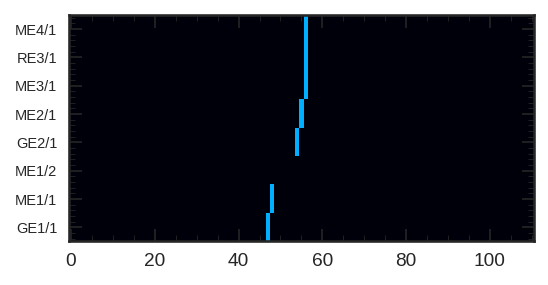

Event 1
pt: 2.788 eta: -1.671


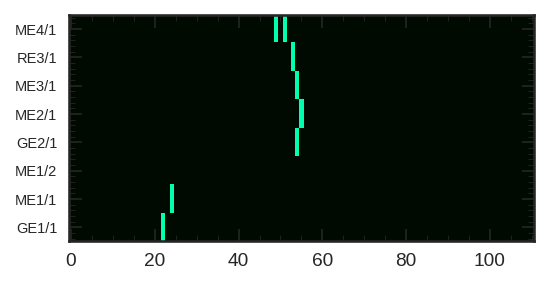

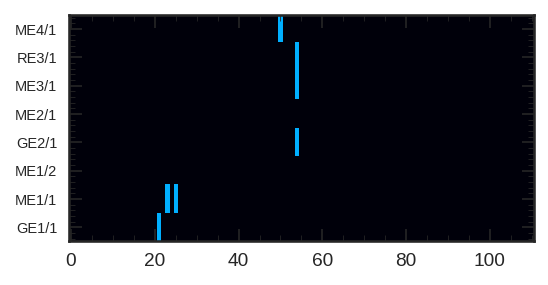

Event 2
pt: 15.031 eta: -1.654


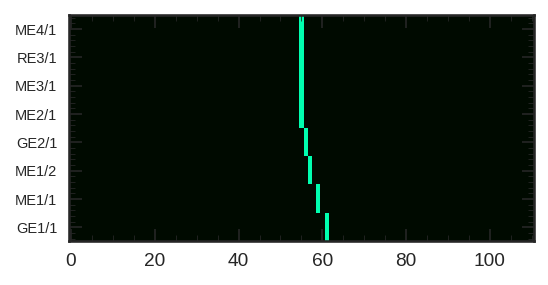

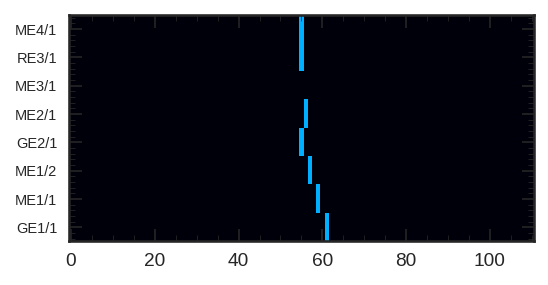

Event 3
pt: 9.663 eta: -1.643


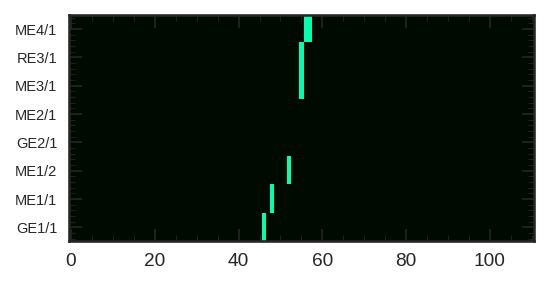

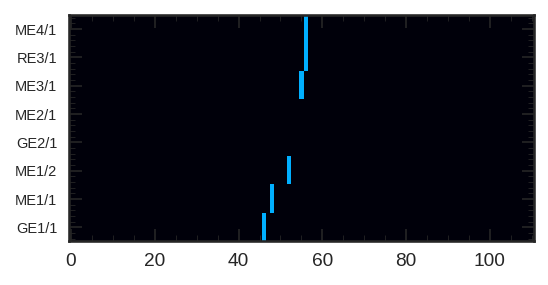

Event 4
pt: 30.876 eta: -1.736


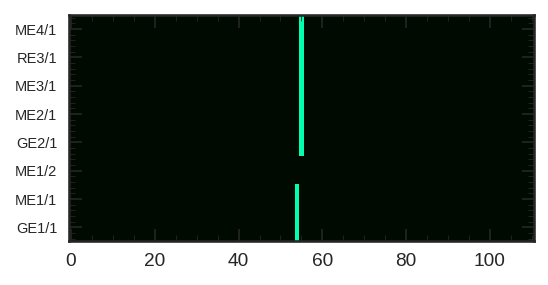

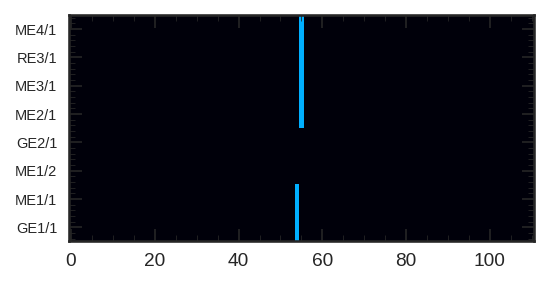

In [21]:
# Debug
for ievt in range(5):
  print('Event {}'.format(ievt))
  print('pt: {:.3f} eta: {:.3f}'.format(zone_part_pt_values[ievt], zone_part_eta_values[ievt]))
  display_zone_image(crop_images_gt[ievt], figsize=(4,2), cmap=cm.green_hot)
  display_zone_image(crop_images[ievt], figsize=(4,2))

In [22]:
# Debug
print(zone_images_anchors[:100])

[266 207  68  90  66 127 152 123  79  55 195 160 140 102 238 166 186 109
  72 185 155  86 152 148 208 242 142  83  95 245  75 170  78 177  80 195
  76 241 215 202 259 103 174  60 120 158  94   1  74  48  72  68 206 272
 143 157  54 238 236 188 168 132 246  70 141  64 264 132 179 243 186  70
 147 177 205 225 254  76 248  69 185 163 163 114 264  77 267  97 277  61
 208 217 159 201 184 268 222 140 172 240]


In [23]:
def build_crop_images_bkg():
  # Refer to build_zone_images() and build_crop_images()
  crop_images_bkg = np.zeros((bkg_aux.shape[0],) + box_image_format, dtype=bool)

  bkg_hits_row_splits = bkg_hits.row_splits
  bkg_hits_emtf_phi = bkg_hits.values[:, sector_hits_fields.emtf_phi]
  bkg_hits_emtf_host = bkg_hits.values[:, sector_hits_fields.emtf_host]
  bkg_hits_zones = bkg_hits.values[:, sector_hits_fields.zones]
  bkg_hits_timezones = bkg_hits.values[:, sector_hits_fields.timezones]
  bkg_hits_valid = bkg_hits.values[:, sector_hits_fields.valid].astype(bool)

  bkg_hits_valid = ((bkg_hits_zones & (1 << ((num_emtf_zones - 1) - zone))).astype(bool) &
                    (bkg_hits_timezones & (1 << ((num_emtf_timezones - 1) - timezone))).astype(bool) &
                    bkg_hits_valid)
  bkg_hits_img_row = find_emtf_img_row(bkg_hits_emtf_host, zone=zone)
  bkg_hits_img_col = find_emtf_img_col(bkg_hits_emtf_phi)

  # Build crop_images_bkg
  _build_crop_images_bkg(bkg_hits_row_splits,
                         bkg_hits_valid,
                         bkg_hits_img_row,
                         bkg_hits_img_col,
                         crop_images_bkg)
  return crop_images_bkg


def _build_crop_images_bkg(bkg_hits_row_splits,
                           bkg_hits_valid,
                           bkg_hits_img_row,
                           bkg_hits_img_col,
                           crop_images_bkg):
  # If valid, set bit at (row, col, channel) to 1
  def func(ievt, valid, row, col):
    # 10 is a fudge number
    anchor = num_cols - num_box_cols - 10
    start = anchor - box_col_offset
    stop = anchor + box_col_offset + 1
    if valid and (row >= 0) and (col >= 0) and (start <= col < stop):
      crop_images_bkg[ievt, row, col - start, 0] = 1

  bkg_hits_row_indices = emtf_nnet.ragged.ragged_row_splits_to_segment_ids(bkg_hits_row_splits)
  iterables = zip(bkg_hits_row_indices, bkg_hits_valid, bkg_hits_img_row, bkg_hits_img_col)
  more_itertools.consume(itertools.starmap(func, iterables))

In [24]:
%%time

crop_images_bkg = build_crop_images_bkg()

logger.info('crop_images_bkg: {}'.format(crop_images_bkg.shape))

[INFO    ] crop_images_bkg: (12592764, 8, 111, 1)


CPU times: user 46 s, sys: 2.56 s, total: 48.6 s
Wall time: 48.6 s


Event 0


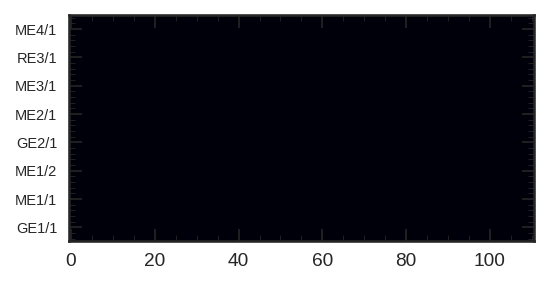

Event 1


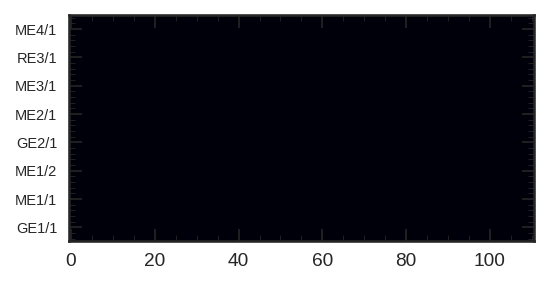

Event 2


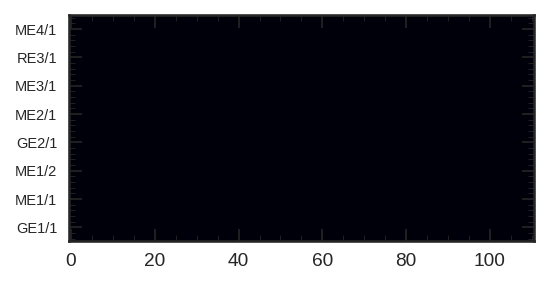

Event 3


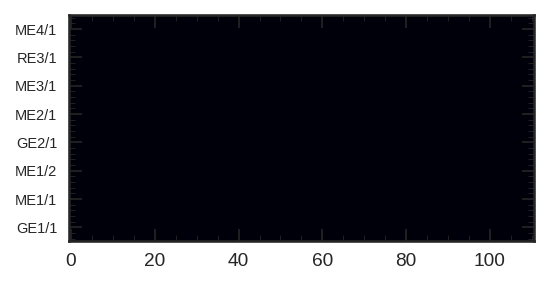

Event 4


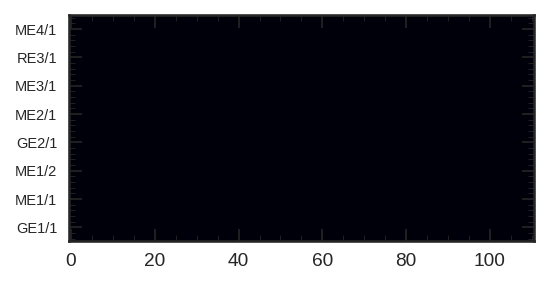

In [25]:
# Debug
for ievt in range(5):
  print('Event {}'.format(ievt))
  display_zone_image(crop_images_bkg[ievt], figsize=(4,2))

In [26]:
# Rebuild boxes from cropped images

def rebuild_boxes():
  # 5 indices: (dzero_bin, invpt_bin, img_row, img_col, img_channel)
  boxes = np.zeros((num_dzero_bins, num_invpt_bins) + box_image_format, dtype=np.float32)

  box_bins = digitize_d0_and_invpt(zone_part[:, part_fields.part_d0],
                                   zone_part[:, part_fields.part_invpt])
  box_bins_mir = ((num_dzero_bins - 1) - box_bins[0],
                  (num_invpt_bins - 1) - box_bins[1])

  # Canon images
  # Use crop_images as input (instead of crop_images_gt)
  _rebuild_boxes(crop_images,
                 box_bins,
                 boxes)
  # Mirror images
  _rebuild_boxes(crop_images[:, :, ::-1, :],
                 box_bins_mir,
                 boxes)
  return (boxes, box_bins)


def _rebuild_boxes(crop_images,
                   box_bins,
                   boxes):
  def func(dzero_bin, invpt_bin, img):
    box = boxes[dzero_bin, invpt_bin]
    box += img

  iterables = zip(box_bins[0], box_bins[1], crop_images)
  more_itertools.consume(itertools.starmap(func, iterables))

In [27]:
%%time

boxes, box_bins = rebuild_boxes()
boxes_norm, boxes = postprocess_boxes(boxes, antialias=False)

logger.info('boxes_norm: {} boxes: {}'.format(boxes_norm.shape, boxes.shape))

[INFO    ] boxes_norm: (7, 7, 8, 111, 1) boxes: (7, 7, 8, 111, 1)


CPU times: user 2.94 s, sys: 80.9 ms, total: 3.02 s
Wall time: 3.02 s


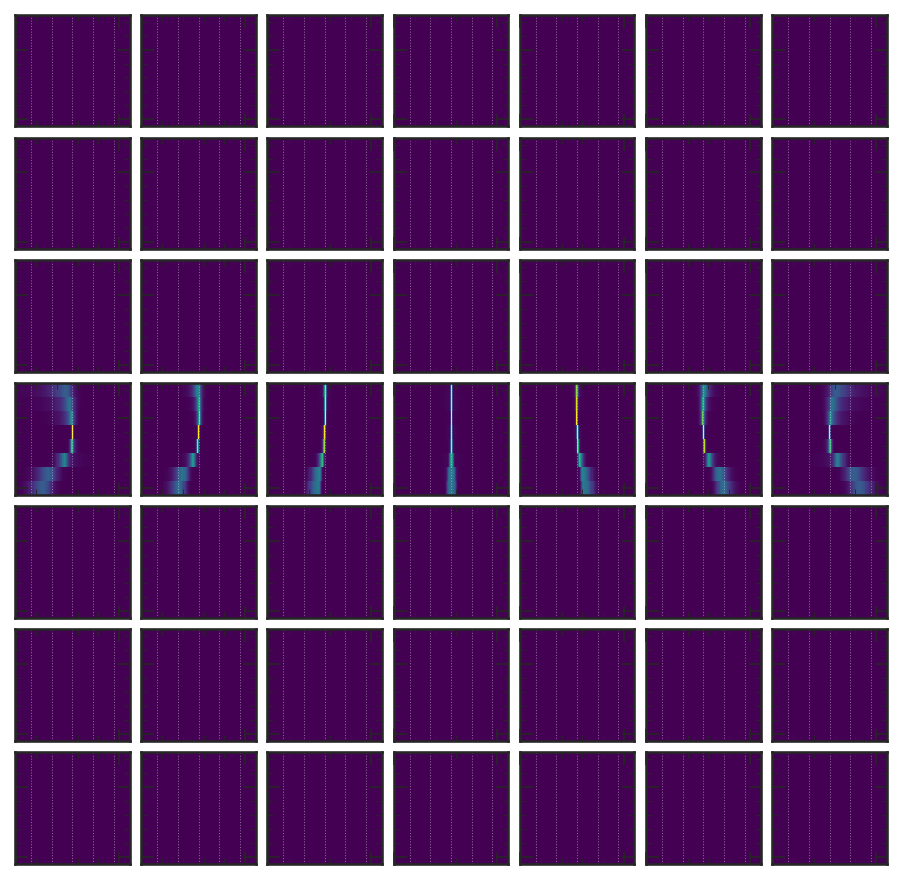

In [28]:
display_boxes(boxes_norm)

### Create patterns

In [29]:
# Apply activation threshold

boxes_act = (boxes_norm > activation)

# Detect weird spikes
def antispike():
  tmp_boxes = boxes_act.copy()
  for i in range(tmp_boxes.shape[0]):
    for j in range(tmp_boxes.shape[1]):
      for k in range(tmp_boxes.shape[2]):
        img = tmp_boxes[i, j, k, :, 0]
        for l in range(1, img.shape[0]-1):
          if img[l] and not img[l-1] and not img[l+1]:
            print('Found spike at {}'.format((i, j, k, l, 0)))


# Detect wide ranges
def antirange():
  tmp_boxes = boxes_act.copy()
  for i in range(tmp_boxes.shape[0]):
    for j in range(tmp_boxes.shape[1]):
      for k in range(tmp_boxes.shape[2]):
        img = tmp_boxes[i, j, k, :, 0]
        for l in range(1, img.shape[0]-1):
          if img[l] and ((l < (box_col_offset - box_col_padding)) or
                         (l > (box_col_offset + box_col_padding))):
            print('Found wide range at {}'.format((i, j, k, l, 0)))


antispike()
antirange()

Found wide range at (3, 0, 0, 13, 0)
Found wide range at (3, 0, 0, 14, 0)
Found wide range at (3, 0, 0, 15, 0)
Found wide range at (3, 0, 0, 16, 0)
Found wide range at (3, 0, 0, 17, 0)
Found wide range at (3, 0, 0, 18, 0)
Found wide range at (3, 0, 1, 18, 0)
Found wide range at (3, 6, 0, 92, 0)
Found wide range at (3, 6, 0, 93, 0)
Found wide range at (3, 6, 0, 94, 0)
Found wide range at (3, 6, 0, 95, 0)
Found wide range at (3, 6, 0, 96, 0)
Found wide range at (3, 6, 0, 97, 0)
Found wide range at (3, 6, 1, 92, 0)


In [30]:
# Ad-hoc fixes

if zone == 0:
  boxes_act[3, 1, 3, 56, 0] = 1  # GE2/1
  boxes_act[3, 5, 3, 54, 0] = 1  # GE2/1
elif zone == 1:
  boxes_act[3, 0, 0, 13:19, 0] = 0  # GE1/1
  boxes_act[3, 0, 0, 38:40, 0] = 1  # GE1/1
  boxes_act[3, 6, 0, 71:73, 0] = 1  # GE1/1
  boxes_act[3, 6, 0, 92:98, 0] = 0  # GE1/1
  #
  boxes_act[3, 0, 1, 18, 0] = 0  # ME1/1
  boxes_act[3, 6, 1, 92, 0] = 0  # ME1/1
  #
  boxes_act[3, 0, 3, 58, 0] = 0  # GE2/1
  boxes_act[3, 1, 3, 56, 0] = 1  # GE2/1
  boxes_act[3, 5, 3, 54, 0] = 1  # GE2/1
  boxes_act[3, 6, 3, 52, 0] = 0  # GE2/1
elif zone == 2:
  boxes_act[3, 2, 0, 55, 0] = 1  # ME1/2
  boxes_act[3, 4, 0, 55, 0] = 1  # ME1/2
  #
  boxes_act[3, 2, 1, 50, 0] = 1  # RE1/2
  boxes_act[3, 4, 1, 60, 0] = 1  # RE1/2
  #
  boxes_act[3, 2, 4, 54, 0] = 1  # ME3/2
  boxes_act[3, 4, 4, 56, 0] = 1  # ME3/2

antispike()
antirange()

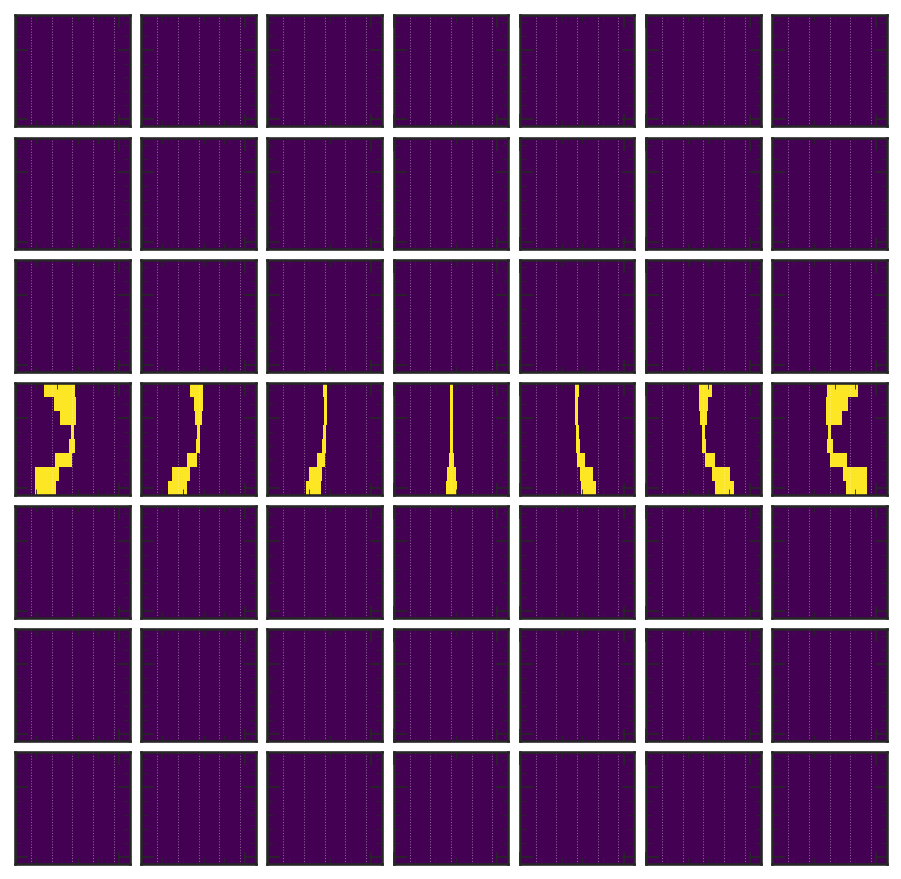

In [31]:
display_boxes(0.8 * boxes_act)

In [32]:
check_pattern_overlaps = False

if check_pattern_overlaps:
  display_box(0.5 * boxes_act[3,3], figsize=(2,2))
  display_box(0.5 * boxes_act[3,3] + 0.5 * boxes_act[3,4], figsize=(2,2))
  display_box(0.5 * boxes_act[3,4] + 0.5 * boxes_act[3,5], figsize=(2,2))
  display_box(0.5 * boxes_act[3,5] + 0.5 * boxes_act[3,6], figsize=(2,2))

In [33]:
check_efficiency_activation = False

if check_efficiency_activation:
  def find_efficiency_activation(tmp_boxes):
    # Count amount of activation before and after applying patterns
    denom = np.zeros((num_dzero_bins, num_invpt_bins), dtype=np.int32)
    numer = np.zeros((num_dzero_bins, num_invpt_bins), dtype=np.int32)

    for i in range(num_dzero_bins):
      for j in range(num_invpt_bins):
        mask = (box_bins[0] == i) & (box_bins[1] == j)
        tmp_images = crop_images[mask]
        tmp_box = tmp_boxes[i, j]
        denom[i, j] = tmp_images.any(axis=-1).any(axis=-1).sum(axis=-1).sum(axis=-1)
        numer[i, j] = (tmp_box & tmp_images).any(axis=-1).any(axis=-1).sum(axis=-1).sum(axis=-1)

    denom[denom == 0] = 1
    result = np.true_divide(numer, denom)
    return result.astype(np.float32)

  with np.printoptions(precision=5):
    for act in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1]:
      tmp_boxes = (boxes_norm > act)
      print(act)
      print(find_efficiency_activation(tmp_boxes))

In [34]:
check_d0_and_invpt_binning = False

if check_d0_and_invpt_binning:
  part_invpt_tmp = zone_part[:, part_fields.part_invpt]
  part_invpt_tmp = np.hstack((part_invpt_tmp, -part_invpt_tmp))
  part_dzero_tmp = zone_part[:, part_fields.part_d0]
  part_dzero_tmp = np.hstack((part_dzero_tmp, -part_dzero_tmp))
  with np.printoptions(precision=5):
    #q = np.percentile(part_invpt_tmp, [0.5,100./7,200./7,300./7,400./7,500./7,600./7,99.5], overwrite_input=True)
    #print('invpt_bins: {}'.format(q))
    #q = np.percentile(part_dzero_tmp, [0.5,300./12,500./12,588./12,612./12,700./12,900./12,99.5], overwrite_input=True)
    #print('dzero_bins: {}'.format(q))
    if zone == 0:
      q = np.percentile(part_invpt_tmp, [0.5, 18.75, 31.25, 43.75, 56.25, 68.75, 81.25, 99.5], overwrite_input=True)
    elif zone == 1:
      q = np.percentile(part_invpt_tmp, [0.5, 17.5, 30.0, 44.0, 56.0, 70.0, 82.5, 99.5], overwrite_input=True)
    elif zone == 2:
      q = np.percentile(part_invpt_tmp, [0.5, 18.75, 31.25, 42.5, 57.5, 68.75, 81.25, 99.5], overwrite_input=True)
    print('invpt_bins: {}'.format(q))

In [35]:
# Debug
for j in range(num_invpt_bins):
  print(1.0 * boxes_act[3, j, anchor_row, box_col_offset-10:box_col_offset+11].reshape(-1))  # ME2

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [36]:
# Debug
for j in range(num_invpt_bins):
  print(1.0 * boxes_act[3, j, anchor_row-1, box_col_offset-10:box_col_offset+11].reshape(-1))  # RE2 or GE2

[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


In [37]:
# Create pattern windows

def create_patterns():
  # Find mid from the weighted mean (using boxes)
  patterns_mid = (boxes[..., 0] * (0.5 + np.arange(num_box_cols))).sum(axis=-1)  # reduce on axis=(-2,-1)
  norm = (boxes[..., 0]).sum(axis=-1)
  norm[norm == 0] = 1
  patterns_mid /= norm

  patterns_mid = patterns_mid.astype(np.int32)
  patterns_start = np.zeros(patterns_mid.shape, dtype=np.int32)
  patterns_stop = np.zeros(patterns_mid.shape, dtype=np.int32)
  assert np.all(patterns_mid[3, :, anchor_row] == box_col_offset)
  assert np.all(patterns_mid[3, 3, :] == box_col_offset)

  # Find start, stop (using boxes_act)
  for i in range(boxes_act.shape[0]):
    for j in range(boxes_act.shape[1]):
      for k in range(boxes_act.shape[2]):
        for l in range(boxes_act.shape[3]):
          if boxes_act[i, j, k, l, 0] == 1:
            patterns_start[i, j, k] = l
            break
        for l in reversed(range(boxes_act.shape[3])):
          if boxes_act[i, j, k, l, 0] == 1:
            patterns_stop[i, j, k] = l
            break

  patterns = np.stack([patterns_start, patterns_mid, patterns_stop])
  patterns = np.moveaxis(patterns, 0, -1)
  patterns_winsz = (patterns_stop - patterns_start + 1)
  patterns_winsz[patterns_winsz == 1] = 0
  assert np.all(patterns_winsz < ((box_col_padding * 2) + 1))

  # Sanity check by recreating boxes_act from patterns
  tmp_boxes = np.zeros(boxes_act.shape, dtype=boxes_act.dtype)
  for i in range(patterns.shape[0]):
    for j in range(patterns.shape[1]):
      for k in range(patterns.shape[2]):
        l0, l1, l2 = patterns[i, j, k]
        if l2 > l0:
          tmp_boxes[i, j, k, l0:l2+1, 0] = 1
  assert np.all(tmp_boxes == boxes_act)

  return (patterns, patterns_winsz)


patterns, patterns_winsz = create_patterns()
logger.info('patterns: {} patterns_winsz: {}'.format(patterns.shape, patterns_winsz.shape))

[INFO    ] patterns: (7, 7, 8, 3) patterns_winsz: (7, 7, 8)


In [38]:
# Debug
print(np.array2string(patterns[3, :], separator=', '))

[[[19, 25, 39],
  [19, 30, 41],
  [39, 48, 54],
  [52, 55, 57],
  [54, 55, 56],
  [43, 51, 58],
  [38, 47, 58],
  [28, 42, 57]],

 [[26, 35, 43],
  [30, 38, 46],
  [44, 49, 53],
  [53, 54, 56],
  [54, 55, 56],
  [52, 55, 58],
  [51, 55, 59],
  [47, 53, 59]],

 [[38, 46, 51],
  [41, 47, 52],
  [48, 52, 55],
  [53, 55, 56],
  [54, 55, 56],
  [55, 56, 57],
  [55, 56, 57],
  [54, 56, 57]],

 [[50, 55, 60],
  [51, 55, 59],
  [53, 55, 57],
  [54, 55, 56],
  [54, 55, 56],
  [54, 55, 56],
  [54, 55, 56],
  [54, 55, 56]],

 [[59, 64, 72],
  [58, 63, 69],
  [55, 58, 62],
  [54, 55, 57],
  [54, 55, 56],
  [53, 54, 55],
  [53, 54, 55],
  [53, 54, 56]],

 [[67, 75, 84],
  [64, 72, 80],
  [57, 61, 66],
  [54, 56, 57],
  [54, 55, 56],
  [52, 55, 58],
  [51, 55, 59],
  [51, 57, 63]],

 [[71, 85, 91],
  [69, 80, 91],
  [56, 62, 71],
  [53, 55, 58],
  [54, 55, 56],
  [52, 59, 67],
  [52, 63, 72],
  [53, 68, 82]]]


In [39]:
# Debug
print(np.array2string(patterns_winsz[3, :], separator=', '))

[[21, 23, 16,  6,  3, 16, 21, 30],
 [18, 17, 10,  4,  3,  7,  9, 13],
 [14, 12,  8,  4,  3,  3,  3,  4],
 [11,  9,  5,  3,  3,  3,  3,  3],
 [14, 12,  8,  4,  3,  3,  3,  4],
 [18, 17, 10,  4,  3,  7,  9, 13],
 [21, 23, 16,  6,  3, 16, 21, 30]]


### Create pattern quality

In [40]:
# Create pattern quality

def create_patterns_quality():
  # Normalize once
  quality_adjust = np.true_divide(patterns_winsz, patterns_winsz[3, 3])
  # l2-sum over axis=-1
  quality_adjust = np.sqrt(np.square(quality_adjust).sum(axis=-1))
  # Normalize again
  quality_adjust_norm = quality_adjust.copy()
  quality_adjust_norm[quality_adjust_norm == 0] = 1
  quality_adjust[quality_adjust != 0] = quality_adjust[3, 3]
  quality_adjust /= quality_adjust_norm
  #print(quality_adjust)

  accumulated = np.zeros((2 ** num_box_rows,), dtype=quality_adjust.dtype)
  accumulated_bkg = np.zeros((2 ** num_box_rows,), dtype=quality_adjust.dtype)
  po2_coeffs = (2 ** np.arange(num_box_rows))  # [1,2,4,8,16,32,64,128]

  # Find hit map
  for i in range(num_dzero_bins):
    for j in range(num_invpt_bins):
      mask = (box_bins[0] == i) & (box_bins[1] == j)
      tmp_images = crop_images[mask]
      if tmp_images.size > 0:
        # Reduce on axis=(-2,-1), then calc dot-product on axis=-3 (row)
        tmp_images = (tmp_images.any(axis=-1).any(axis=-1) * po2_coeffs).sum(axis=-1)
        # np.bincount() is like np.histogram() for unit bin size
        accumulated += (np.bincount(tmp_images) * quality_adjust[i, j])

  # Find hit map (bkg)
  tmp_images = crop_images_bkg
  tmp_images = (tmp_images.any(axis=-1).any(axis=-1) * po2_coeffs).sum(axis=-1)
  accumulated_bkg += np.bincount(tmp_images)
  accumulated_bkg[accumulated_bkg == 0] = 1
  #print(accumulated.min(), accumulated.max(), accumulated.argmin(), accumulated.argmax())
  #print(accumulated_bkg.min(), accumulated_bkg.max(), accumulated_bkg.argmin(), accumulated_bkg.argmax())

  # Calc S/sqrt(B)
  patterns_quality = accumulated.astype(np.float32)
  # Make sure all the bins are nonzero
  patterns_quality[patterns_quality < 1e-5] = patterns_quality[patterns_quality >= 1e-5].min()
  patterns_quality[0] = 0  # set to zero if empty hit
  patterns_quality[po2_coeffs] = 0  # set to zero if single hit
  patterns_quality /= np.sqrt(accumulated_bkg)

  patterns_quality_indices = np.argsort(patterns_quality)
  patterns_quality_ranks = np.zeros(patterns_quality.shape, dtype=np.int32)
  patterns_quality_ranks[patterns_quality_indices] = np.arange(patterns_quality.shape[0])
  return (patterns_quality, patterns_quality_indices, patterns_quality_ranks)


patterns_quality, patterns_quality_indices, patterns_quality_ranks = create_patterns_quality()
logger.info('patterns_quality: {} patterns_quality_indices: {} patterns_quality_ranks: {}'.format(
    patterns_quality.shape, patterns_quality_indices.shape, patterns_quality_ranks.shape))

[INFO    ] patterns_quality: (256,) patterns_quality_indices: (256,) patterns_quality_ranks: (256,)


In [41]:
# Debug
with np.printoptions(threshold=10):
  print(patterns_quality.min(), patterns_quality.max())
  print(patterns_quality)
  print(patterns_quality_indices)
  print(patterns_quality_ranks)
  print()

for i in range(0, 256, 8):
  s = ' '.join(['{:08b}'] * 8)
  print(s.format(*patterns_quality_indices[i:i+8]))

0.0 959.1401
[  0.         0.         0.       ...   6.887323  20.182585 243.48795 ]
[  0   1   2 ... 231 219 251]
[  0   1   2 ... 175 212 248]

00000000 00000001 00000010 10000000 00000100 00001000 00100000 01000000
00010000 00000101 10001000 01000001 10000001 00100001 00001101 10000010
01000010 00001110 01001101 00000110 00010110 01100001 10001110 00100010
00001111 10001001 00110000 01101101 00110110 00101101 00000111 01000110
00101000 11000001 00111101 01100010 00010101 00001001 11000010 00011101
01101110 01100000 00000011 00101110 10101101 01010110 00010111 11001000
01001110 00111110 01001000 01001001 01111101 10001100 01000011 10000011
10010000 00101111 01101000 00101001 00101100 01110000 00001010 10001010
10101100 00010001 00011110 00111000 01010101 01001111 11001101 00110010
01000101 01001010 10001101 01101111 11001001 00110101 01000111 01010001
10101000 01010010 01101001 00100011 01110110 11101000 00110001 00010010
10100010 10100001 01011101 01111110 10010001 11001110 10000110

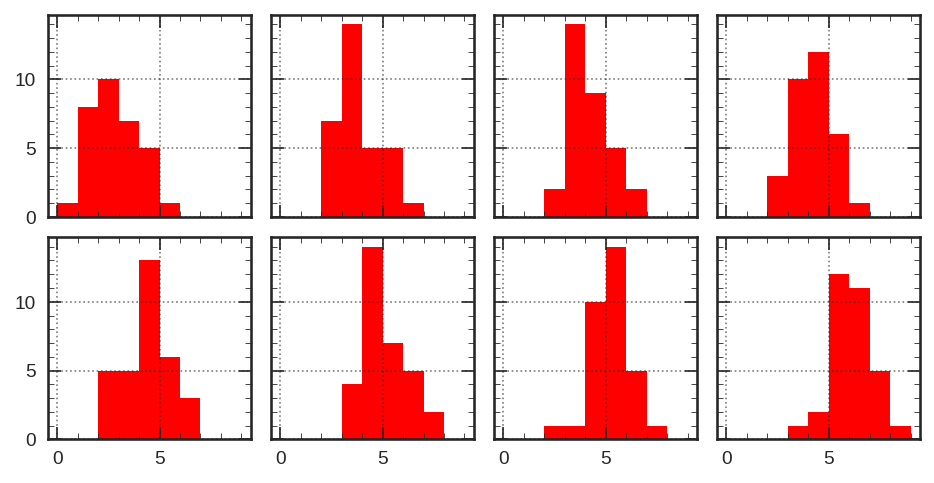

In [42]:
fig, axs = plt.subplots(2, 4, figsize=(7.5, 7.5/2), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.1))

for i in range(8):
  ax = axs[i//4, i%4]
  hist = np.zeros(num_box_rows + 1, dtype=np.int32)
  edges = np.arange(hist.shape[0] + 1)
  chunks = np.split(patterns_quality_indices, 8)
  for j in chunks[i]:
    kk = 0
    for k in range(num_box_rows):  # count num of set bits
      if j & (1 << k):
        kk += 1
    hist[kk] += 1

  hist_on_binned_data(hist, edges=edges, color='red', ax=ax)

plt.show()

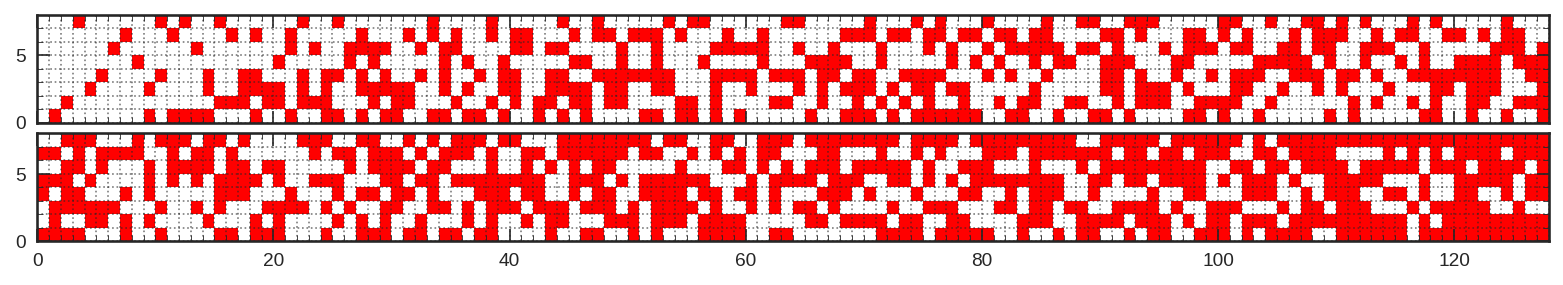

In [43]:
from matplotlib.ticker import AutoMinorLocator

fig, axs = plt.subplots(2, 1, figsize=(13, 2), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.1))

for i in range(2):
  ax = axs[i]
  hist = np.zeros((patterns_quality_indices.shape[0] // 2, num_box_rows), dtype=np.int32)
  xedges = np.arange(hist.shape[0] + 1)
  yedges = np.arange(hist.shape[1] + 1)
  chunks = np.split(patterns_quality_indices, 2)
  for j in chunks[i]:
    jj = patterns_quality_ranks[j] % (patterns_quality_indices.shape[0] // 2)
    for k in range(num_box_rows):  # check set bits
      if j & (1 << k):
        hist[jj, k] = 1

  hist2d_on_binned_data(hist, xedges=xedges, yedges=yedges, cmap=cm.red_binary, ax=ax)
  ax.grid(True, which='both')
  ax.xaxis.set_minor_locator(AutoMinorLocator(20))
  ax.yaxis.set_minor_locator(AutoMinorLocator(5))

plt.show()

In [44]:
# Write to file
outfile = 'patterns_zone%i.npz' % zone
outdict = {
  'patterns': patterns,
  'patterns_winsz': patterns_winsz,
  'patt_filters': boxes_act,
  'patt_activations': patterns_quality_ranks,
}
save_np_arrays(outfile, outdict)
logger.info('Wrote to {}'.format(outfile))

[INFO    ] Wrote to patterns_zone1.npz
